In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import export_text
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from IPython.display import display

!pip install xgboost
%matplotlib inline


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
data = 'https://github.com/gastonstat/CreditScoring/blob/master/CreditScoring.csv'

In [4]:
#!wget $data

In [5]:
df = pd.read_csv('CreditScoring.csv')

In [6]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.status = df.status.map({1: 'ok', 2: 'default', 0: 'unknown'})

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
df.records = df.records.map(records_values)

job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [10]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999.0, value=np.nan)

In [12]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
df = df[df.status != 'unknown'].reset_index(drop=True)

In [14]:
df.status.value_counts()

status
ok         3200
default    1254
Name: count, dtype: int64

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

In [16]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [17]:
len(df_train), len(df_test), len(df_val)

(2672, 891, 891)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [20]:
del df_train['status']
del df_val['status']
del df_test['status']

In [21]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


In [22]:
df_test

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,3,owner,36,26,single,no,freelance,35,0.0,60000.0,3000.0,800,1000
1,10,rent,60,28,married,no,fixed,78,325.0,18.0,3000.0,2250,2250
2,14,rent,60,41,married,no,fixed,53,181.0,0.0,0.0,1150,2497
3,4,owner,60,39,married,no,freelance,45,0.0,7500.0,0.0,1300,1508
4,1,other,30,20,single,no,fixed,35,90.0,0.0,0.0,450,500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,19,owner,12,42,married,no,fixed,90,464.0,5000.0,0.0,1100,2413
887,7,owner,36,24,married,no,fixed,45,95.0,3000.0,0.0,1000,1597
888,0,owner,24,28,married,no,partime,45,219.0,6000.0,0.0,600,943
889,8,other,36,30,married,yes,freelance,75,100.0,4000.0,1365.0,1220,1745


In [23]:
xi = df.iloc[0].to_dict()

In [24]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [25]:
assess_risk(xi)

'default'

In [26]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [27]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [28]:
X_train

array([[3.60e+01, 1.00e+03, 1.00e+04, ..., 0.00e+00, 1.00e+01, 3.60e+01],
       [3.20e+01, 1.10e+03, 0.00e+00, ..., 1.00e+00, 6.00e+00, 4.80e+01],
       [4.00e+01, 1.32e+03, 0.00e+00, ..., 0.00e+00, 1.00e+00, 4.80e+01],
       ...,
       [1.90e+01, 4.00e+02, 0.00e+00, ..., 0.00e+00, 1.00e+00, 2.40e+01],
       [4.30e+01, 2.50e+03, 1.80e+04, ..., 0.00e+00, 1.50e+01, 4.80e+01],
       [2.70e+01, 4.50e+02, 5.00e+03, ..., 1.00e+00, 1.20e+01, 4.80e+01]],
      shape=(2672, 29))

In [29]:
dv.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [30]:
dt = DecisionTreeClassifier()

In [31]:
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [32]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [33]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [34]:
roc_auc_score(y_val, y_pred)

0.6567411784650409

In [35]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [36]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7761016984958594
val: 0.7761016984958594


In [37]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



In [38]:

data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

In [39]:
df_example = pd.DataFrame(data, columns=['assest', 'debt', 'status'])
df_example

,assest,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [40]:
df_example.sort_values('assest')

,assest,debt,status
2,0,1000,default
1,2000,1000,default
7,3000,2000,default
5,4000,1000,ok
4,5000,1000,ok
3,5000,1000,ok
0,8000,3000,default
6,9000,500,ok


In [41]:
Ts = [500, 1000, 2000]

In [42]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assest <= T]
    df_right = df_example[df_example.assest > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    print()

500


,assest,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

1000


,assest,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assest,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64



In [43]:
T = 4000
print(T)
df_left = df_example[df_example.assest <= T]
df_right = df_example[df_example.assest > T]

display(df_left)
df_left.status.value_counts(normalize=True)
display(df_right)
df_right.status.value_counts(normalize=True) 

4000


,assest,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

In [44]:
thresolds = {
    'assests': [0, 2000, 3000, 4000, 5000, 8000],
    'debt':  [500, 1000, 2000]
}

In [45]:
for feature, Ts in thresolds.items():
    print('#####################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example.assest <= T]
        df_right = df_example[df_example.assest > T]
    
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        print()

#####################
assests
0


,assest,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assest,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assest,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assest,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assest,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assest,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
debt
500


,assest,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

1000


,assest,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assest,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assest,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64



In [46]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.757
  10 -> 0.685
  15 -> 0.664
  20 -> 0.654
None -> 0.653


In [47]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [48]:
scores_df = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [49]:
scores_df.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
40,10.0,15,0.788235
58,20.0,15,0.787675
67,NaN,15,0.787345
49,15.0,15,0.785525
50,15.0,20,0.785501
...,...,...,...
53,15.0,500,0.679842
71,NaN,500,0.679842
63,NaN,1,0.665142
45,15.0,1,0.658346


In [50]:
df_scores_pivot = scores_df.pivot(index=['min_samples_leaf'], columns=['max_depth'], values=['auc'])

In [51]:
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.665  0.761  0.767  0.760  0.732  0.709  0.658  0.654
2                 0.694  0.761  0.767  0.765  0.758  0.691  0.684  0.682
5                 0.718  0.761  0.768  0.760  0.758  0.730  0.717  0.720
10                0.758  0.761  0.762  0.778  0.764  0.767  0.758  0.764
15                0.787  0.764  0.773  0.785  0.780  0.788  0.786  0.788
20                0.784  0.761  0.774  0.774  0.779  0.783  0.786  0.782
100               0.779  0.756  0.763  0.776  0.780  0.779  0.780  0.779
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

In [52]:
#plt.plot(scores_df.min_samples_leaf, scores_df.auc) not the best visual heatmap is better 

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

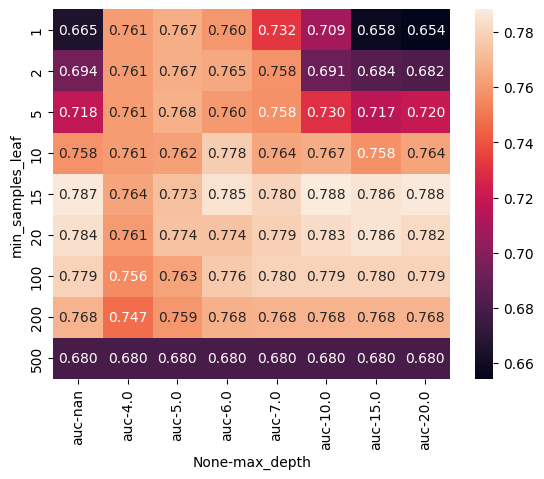

In [53]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [54]:
#final tuning 6 and 15
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [55]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.783845147853043

In [56]:
scoress = []
for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    scoress.append((n, auc))

In [57]:
scoress_df = pd.DataFrame(scoress, columns=['n_estimator', 'auc'])

In [58]:
scoress_df.sort_values(by='auc', ascending=False)

,n_estimator,auc
19,200,0.819050
12,130,0.818253
13,140,0.818102
18,190,0.817981
15,160,0.817981
11,120,0.817939
16,170,0.817606
9,100,0.817599
10,110,0.817527
17,180,0.817463


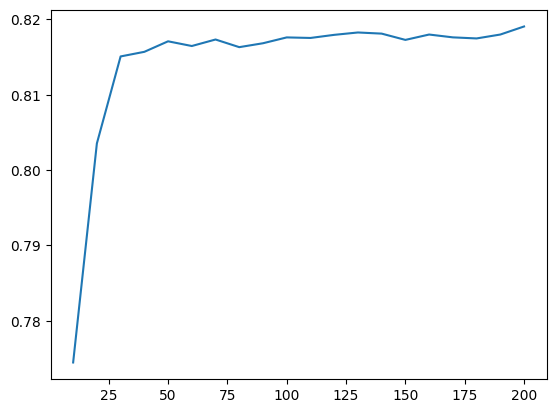

In [59]:
plt.plot(scoress_df.n_estimator, scoress_df.auc)

In [60]:
scored = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scored.append((n, d, auc))

In [61]:
scored_df = pd.DataFrame(scored, columns=['n_estimator', 'max_depth', 'auc'])

In [62]:
scored_df

,n_estimator,max_depth,auc
0,10,5,0.787699
1,20,5,0.797731
2,30,5,0.800305
3,40,5,0.799708
4,50,5,0.799878
5,60,5,0.801167
6,70,5,0.802251
7,80,5,0.803244
8,90,5,0.803616
9,100,5,0.804452


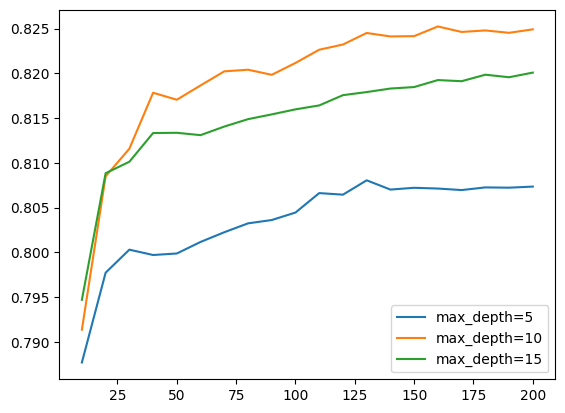

In [63]:
for d in [5, 10, 15]:
    df_subset = scored_df[scored_df.max_depth == d]
    plt.plot(df_subset.n_estimator, df_subset.auc, label='max_depth=%d' % d)
plt.legend()

In [64]:
max_depth = 10

In [65]:
scoreds = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
    
        scoreds.append((s, n, auc))

In [66]:
scoreds_df = pd.DataFrame(scored, columns=['min_samples_leaf', 'n_estimator', 'auc'])
scoreds_df

,min_samples_leaf,n_estimator,auc
0,10,5,0.787699
1,20,5,0.797731
2,30,5,0.800305
3,40,5,0.799708
4,50,5,0.799878
5,60,5,0.801167
6,70,5,0.802251
7,80,5,0.803244
8,90,5,0.803616
9,100,5,0.804452


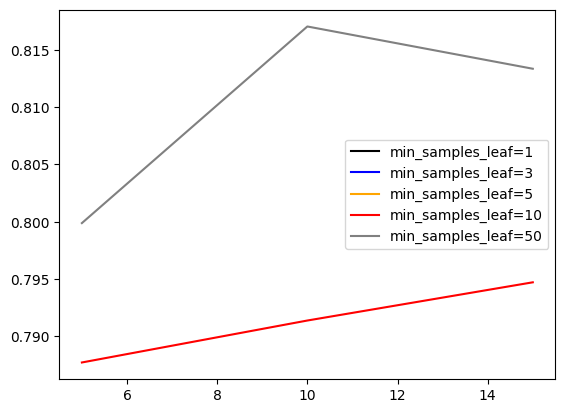

In [67]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]

for s, col in zip(min_samples_leaf_values, colors):
    df_subset = scoreds_df[scoreds_df.min_samples_leaf == s]
    plt.plot(df_subset.n_estimator, df_subset.auc, color=col, label='min_samples_leaf=%s' % s)
plt.legend()

In [68]:
min_samples_leaf = 3

In [69]:
rf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [70]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [71]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [72]:
y_pred = model.predict(dval)

In [73]:
roc_auc_score(y_val, y_pred)

0.8060200770143614

In [74]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [75]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [76]:
s = output.stdout
 
print(s)

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92969	val-auc:0.80822
[10]	train-auc:0.95512	val-auc:0.81115
[15]	train-auc:0.96767	val-auc:0.81993
[20]	train-auc:0.97648	val-auc:0.81877
[25]	train-auc:0.98248	val-auc:0.81520
[30]	train-auc:0.98844	val-auc:0.81613
[35]	train-auc:0.99244	val-auc:0.81453
[40]	train-auc:0.99393	val-auc:0.81407
[45]	train-auc:0.99568	val-auc:0.81392
[50]	train-auc:0.99723	val-auc:0.81276
[55]	train-auc:0.99804	val-auc:0.81299
[60]	train-auc:0.99861	val-auc:0.81244
[65]	train-auc:0.99916	val-auc:0.81197
[70]	train-auc:0.99962	val-auc:0.81243
[75]	train-auc:0.99975	val-auc:0.81152
[80]	train-auc:0.99989	val-auc:0.81359
[85]	train-auc:0.99993	val-auc:0.81193
[90]	train-auc:0.99998	val-auc:0.81038
[95]	train-auc:0.99999	val-auc:0.80871
[100]	train-auc:0.99999	val-auc:0.80842
[105]	train-auc:1.00000	val-auc:0.80778
[110]	train-auc:1.00000	val-auc:0.80764
[115]	train-auc:1.00000	val-auc:0.80722
[120]	train-auc:1.00000	val-auc:0.80750
[125]	train-auc:1.0000

In [77]:
def parse_xgb_output(output):
    results = []
 
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
 
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
 
        results.append((it, train, val))
     
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [78]:
df_scorex = parse_xgb_output(output)
df_scorex

,num_iter,train_auc,val_auc
0,0,0.86653,0.77999
1,5,0.92969,0.80822
2,10,0.95512,0.81115
3,15,0.96767,0.81993
4,20,0.97648,0.81877
5,25,0.98248,0.81520
6,30,0.98844,0.81613
7,35,0.99244,0.81453
8,40,0.99393,0.81407
9,45,0.99568,0.81392


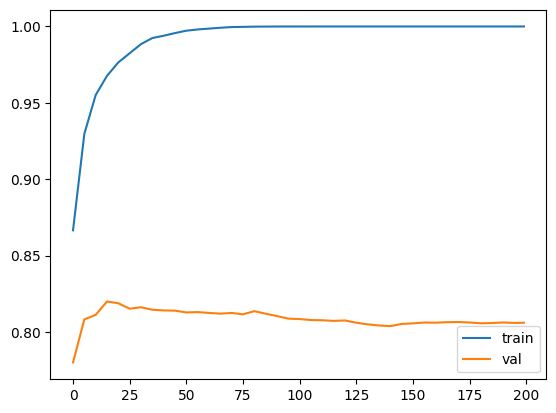

In [79]:
# x-axis - number of iterations
# y-axis - auc
plt.plot(df_scorex.num_iter, df_scorex.train_auc, label='train')
plt.plot(df_scorex.num_iter, df_scorex.val_auc, label='val')
plt.legend()

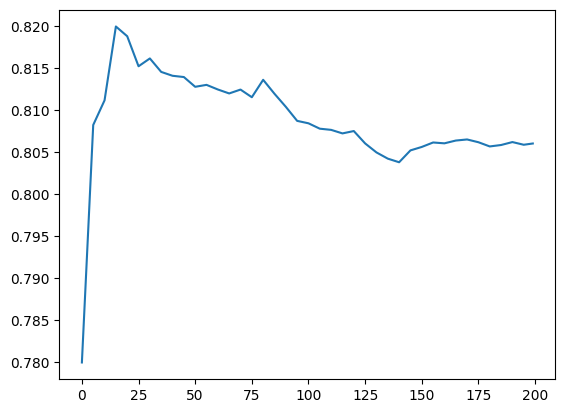

In [80]:
plt.plot(df_scorex.num_iter, df_scorex.val_auc, label='val')

In [81]:
scores = {}

In [82]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [83]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.3'

In [84]:
scores.keys()

dict_keys(['eta=0.3'])

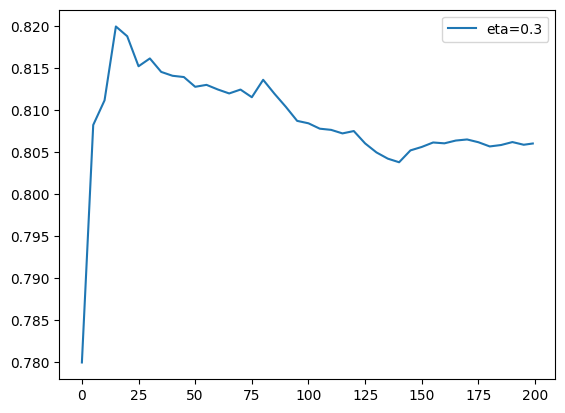

In [85]:
for key, df_scorex in scores.items():
    plt.plot(df_scorex.num_iter, df_scorex.val_auc, label=key)
plt.legend()

In [86]:
scores = {}

In [87]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [88]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

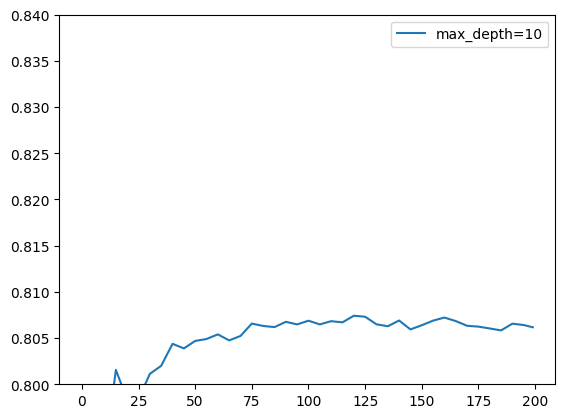

In [89]:
for max_depth, df_scorex in scores.items():
    plt.plot(df_scorex.num_iter, df_scorex.val_auc, label=max_depth)
plt.ylim(0.8, 0.84)
plt.legend()

In [90]:
scores = {}

In [91]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, evals=watchlist, verbose_eval=5, num_boost_round=200)

In [92]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

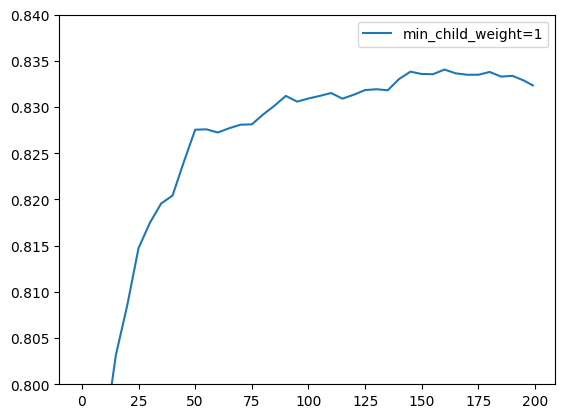

In [93]:
for min_child_weight, df_scorex in scores.items():
    plt.plot(df_scorex.num_iter, df_scorex.val_auc, label=min_child_weight)
plt.ylim(0.8, 0.84)
plt.legend()

In [94]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [95]:
#performance
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8334715797631446

In [96]:
#final tuning 6 and 15
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [97]:
#performance
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7853194400716863

In [98]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [99]:
#performance
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

In [100]:
#train final model

df_full_train = df_full_train.reset_index(drop=True)

In [101]:
df_full_train

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,22,owner,48,48,married,no,fixed,60,110.0,3000.0,0.0,1000,1460
1,default,8,other,60,41,married,no,freelance,45,62.0,0.0,0.0,1800,2101
2,ok,2,parents,36,19,married,no,fixed,35,162.0,4000.0,100.0,400,570
3,ok,1,owner,12,61,married,no,others,45,103.0,20000.0,0.0,300,650
4,ok,13,owner,60,27,married,no,fixed,35,253.0,7000.0,0.0,1060,1750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3558,default,4,owner,60,47,married,no,freelance,75,0.0,13500.0,0.0,1900,1976
3559,ok,2,rent,60,28,single,no,fixed,45,101.0,0.0,0.0,1300,1333
3560,ok,2,parents,36,25,single,no,fixed,35,110.0,0.0,0.0,500,1200
3561,ok,4,other,60,25,single,no,fixed,35,162.0,0.0,0.0,1800,2999


In [102]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [103]:
y_full_train

array([0, 1, 0, ..., 0, 0, 1], shape=(3563,))

In [104]:
del df_full_train['status']

In [105]:
dict_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

dict_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dict_test)

In [106]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

ValueError: ('feature names must have the same length as the number of data columns, ', 'expected 29, got 26')

In [ ]:
dv.get_feature_names_out().tolist()